In [1]:
import os

import numpy as np

from dynamic_programming.mdp_model import MDPModel
from envs.env_creator import env_creator
from base_rl.eval_policy import EvalDiscreteStatePolicy
import time
import pandas as pd
from rmin.train import RMinTrainer
from dynamic_programming.policy import DPPolicy
from envs.plot import plot_industrial_benchmark_trajectories
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
plt.rcParams["figure.figsize"] = [20, 12]

## Load Data and MDP Model

In [3]:
trajectories_samples = ['trajectory_ep10_model_aeq.npy', 'trajectory_ep10_model_final_h.npy',
                        'trajectory_ep10_model_h_c.npy', 'trajectory_ep100_model_aeq.npy',
                        'trajectory_ep100_model_final_h.npy', 'trajectory_ep100_model_h_c.npy',
                        'trajectory_ep1000_model_aeq.npy', 'trajectory_ep1000_model_h_c.npy',
                        'trajectory_ep1000_model_final_h.npy']

min_count = [1, 1, 1, 3, 3, 6, 5, 7, 7]
#min_count = [1, 6, 7]
device = 'cpu'
mdp_save_paths = [f'tmp/rmin/mdp_{file.split(".")[0]}.pkl' for file in trajectories_samples]
model_names = [''.join(file.split(".")[0].split('ep')[-1].split('_', maxsplit=1)[-1]) for file in trajectories_samples]
quant_models_paths = [f'tmp/state_quantization/{model_name}' for model_name in model_names]
policies_save_paths = [f'tmp/rmin/ib_policy_{file.split(".")[0]}.pkl' for file in trajectories_samples]

## Create MDP Models

In [4]:
from dynamic_programming.mdp_model import create_mdp_models

for i, sample_file in enumerate(trajectories_samples):
    load_path = os.path.join("tmp", "offline_rl_trajectories", sample_file)
    create_mdp_models(load_path=load_path, mdp_save_path=mdp_save_paths[i], sa_reward=True, device=device)

Computing Reward Function
Computing Transition Model
tmp/rmin/mdp_trajectory_ep10_model_aeq.pkl
-488.79206098716736
100000
0.0
1219
Computing Reward Function
Computing Transition Model
tmp/rmin/mdp_trajectory_ep10_model_final_h.pkl
-418.9604818501282
100000
0.0
1053
Computing Reward Function
Computing Transition Model
tmp/rmin/mdp_trajectory_ep10_model_h_c.pkl
-491.83630801460265
100000
0.0
1087
Computing Reward Function
Computing Transition Model
tmp/rmin/mdp_trajectory_ep100_model_aeq.pkl
-465.04649392097474
1100000
0.0
1705
Computing Reward Function
Computing Transition Model
tmp/rmin/mdp_trajectory_ep100_model_final_h.pkl
-459.6530046223068
1100000
0.0
1582
Computing Reward Function
Computing Transition Model
tmp/rmin/mdp_trajectory_ep100_model_h_c.pkl
-469.59514335449217
1100000
0.0
1589
Computing Reward Function
Computing Transition Model
tmp/rmin/mdp_trajectory_ep1000_model_aeq.pkl
-464.0242250982178
11100000
0.0
2071
Computing Reward Function
Computing Transition Model
tmp/rmin

## Train

trajectory_ep10_model_aeq.npy
Epoch: 33


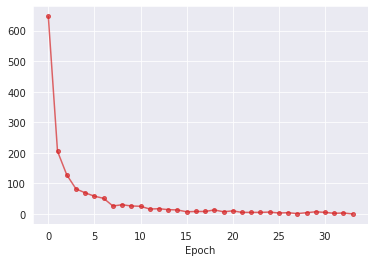

trajectory_ep10_model_final_h.npy
Epoch: 31


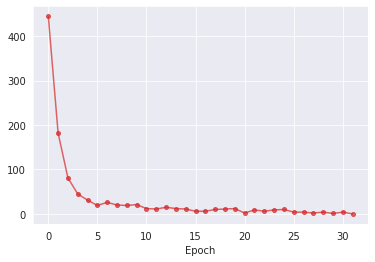

trajectory_ep10_model_h_c.npy
Epoch: 21


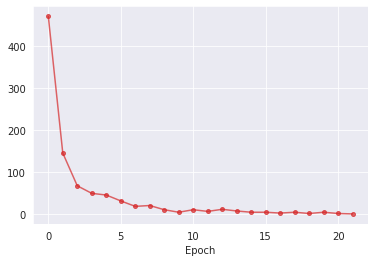

trajectory_ep100_model_aeq.npy
Epoch: 73


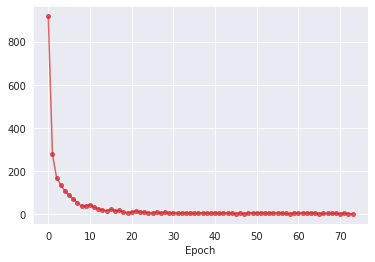

trajectory_ep100_model_final_h.npy
Epoch: 36


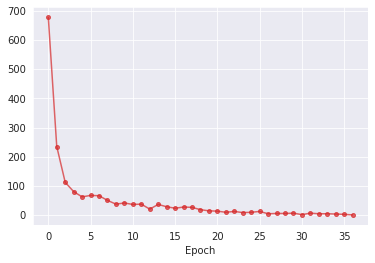

trajectory_ep100_model_h_c.npy
Epoch: 30


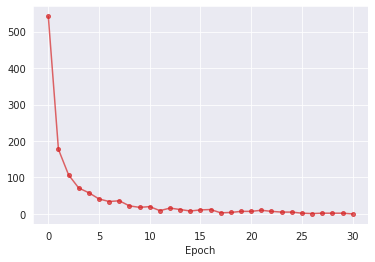

trajectory_ep1000_model_aeq.npy
Epoch: 79


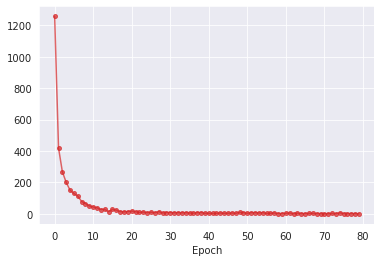

trajectory_ep1000_model_h_c.npy
Epoch: 34


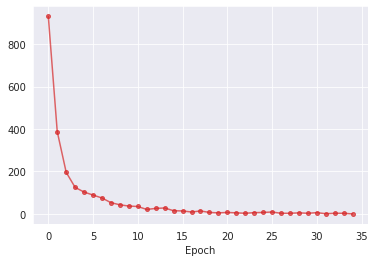

trajectory_ep1000_model_final_h.npy
Epoch: 38


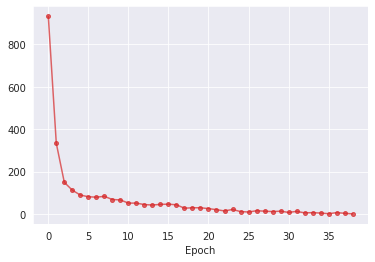

In [4]:
def train_r_min(mdp_path, policy_save_path):
    mdp_model = MDPModel.load(mdp_path)
    solver = RMinTrainer(reward_function=mdp_model.reward_function, transition_model=mdp_model.transition_model,
                         count_state_action=mdp_model.count_state_action, min_count=min_count[i])
    solver.train(epochs=50000, gamma=0.99)
    trained_policy = DPPolicy(policy_table=solver.get_policy(), state_to_index=mdp_model.state_to_index,
                              index_to_action=mdp_model.index_to_actions)
    trained_policy.save(policy_save_path)


for i, mdp_save_path in enumerate(mdp_save_paths):
    print(trajectories_samples[i])
    train_r_min(mdp_path=mdp_save_path, policy_save_path=policies_save_paths[i])




## Evaluate

Episode 9 Reward: -227.27249459046917 || New State Found: False


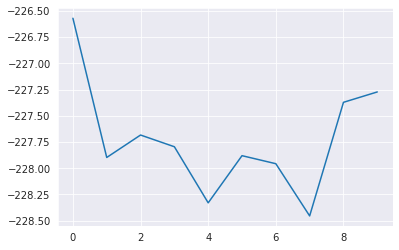

Reward Mean: -227.7209654678441
Reward std : 0.5172064171396398


In [5]:
from benchmarks.policy_benchmarks import PolicyBenchmarks

steps_per_episode = 1000
evaluators = []
for i, policy_file in enumerate(policies_save_paths):
    eval_policy = DPPolicy.load(policy_file)
    env_kwargs = {'steps_per_episode': steps_per_episode, 'device': device, 'model_path': quant_models_paths[i]}
    evaluator = EvalDiscreteStatePolicy(policy=eval_policy, env_creator=env_creator, env_kwargs=env_kwargs,
                                        tag=policy_file.split('/')[-1].split('.')[0])
    evaluators.append(evaluator)

policy_benchmarks = PolicyBenchmarks(evaluators=evaluators, epochs=10)
policy_benchmarks.benchmark()

-198.00789639194892

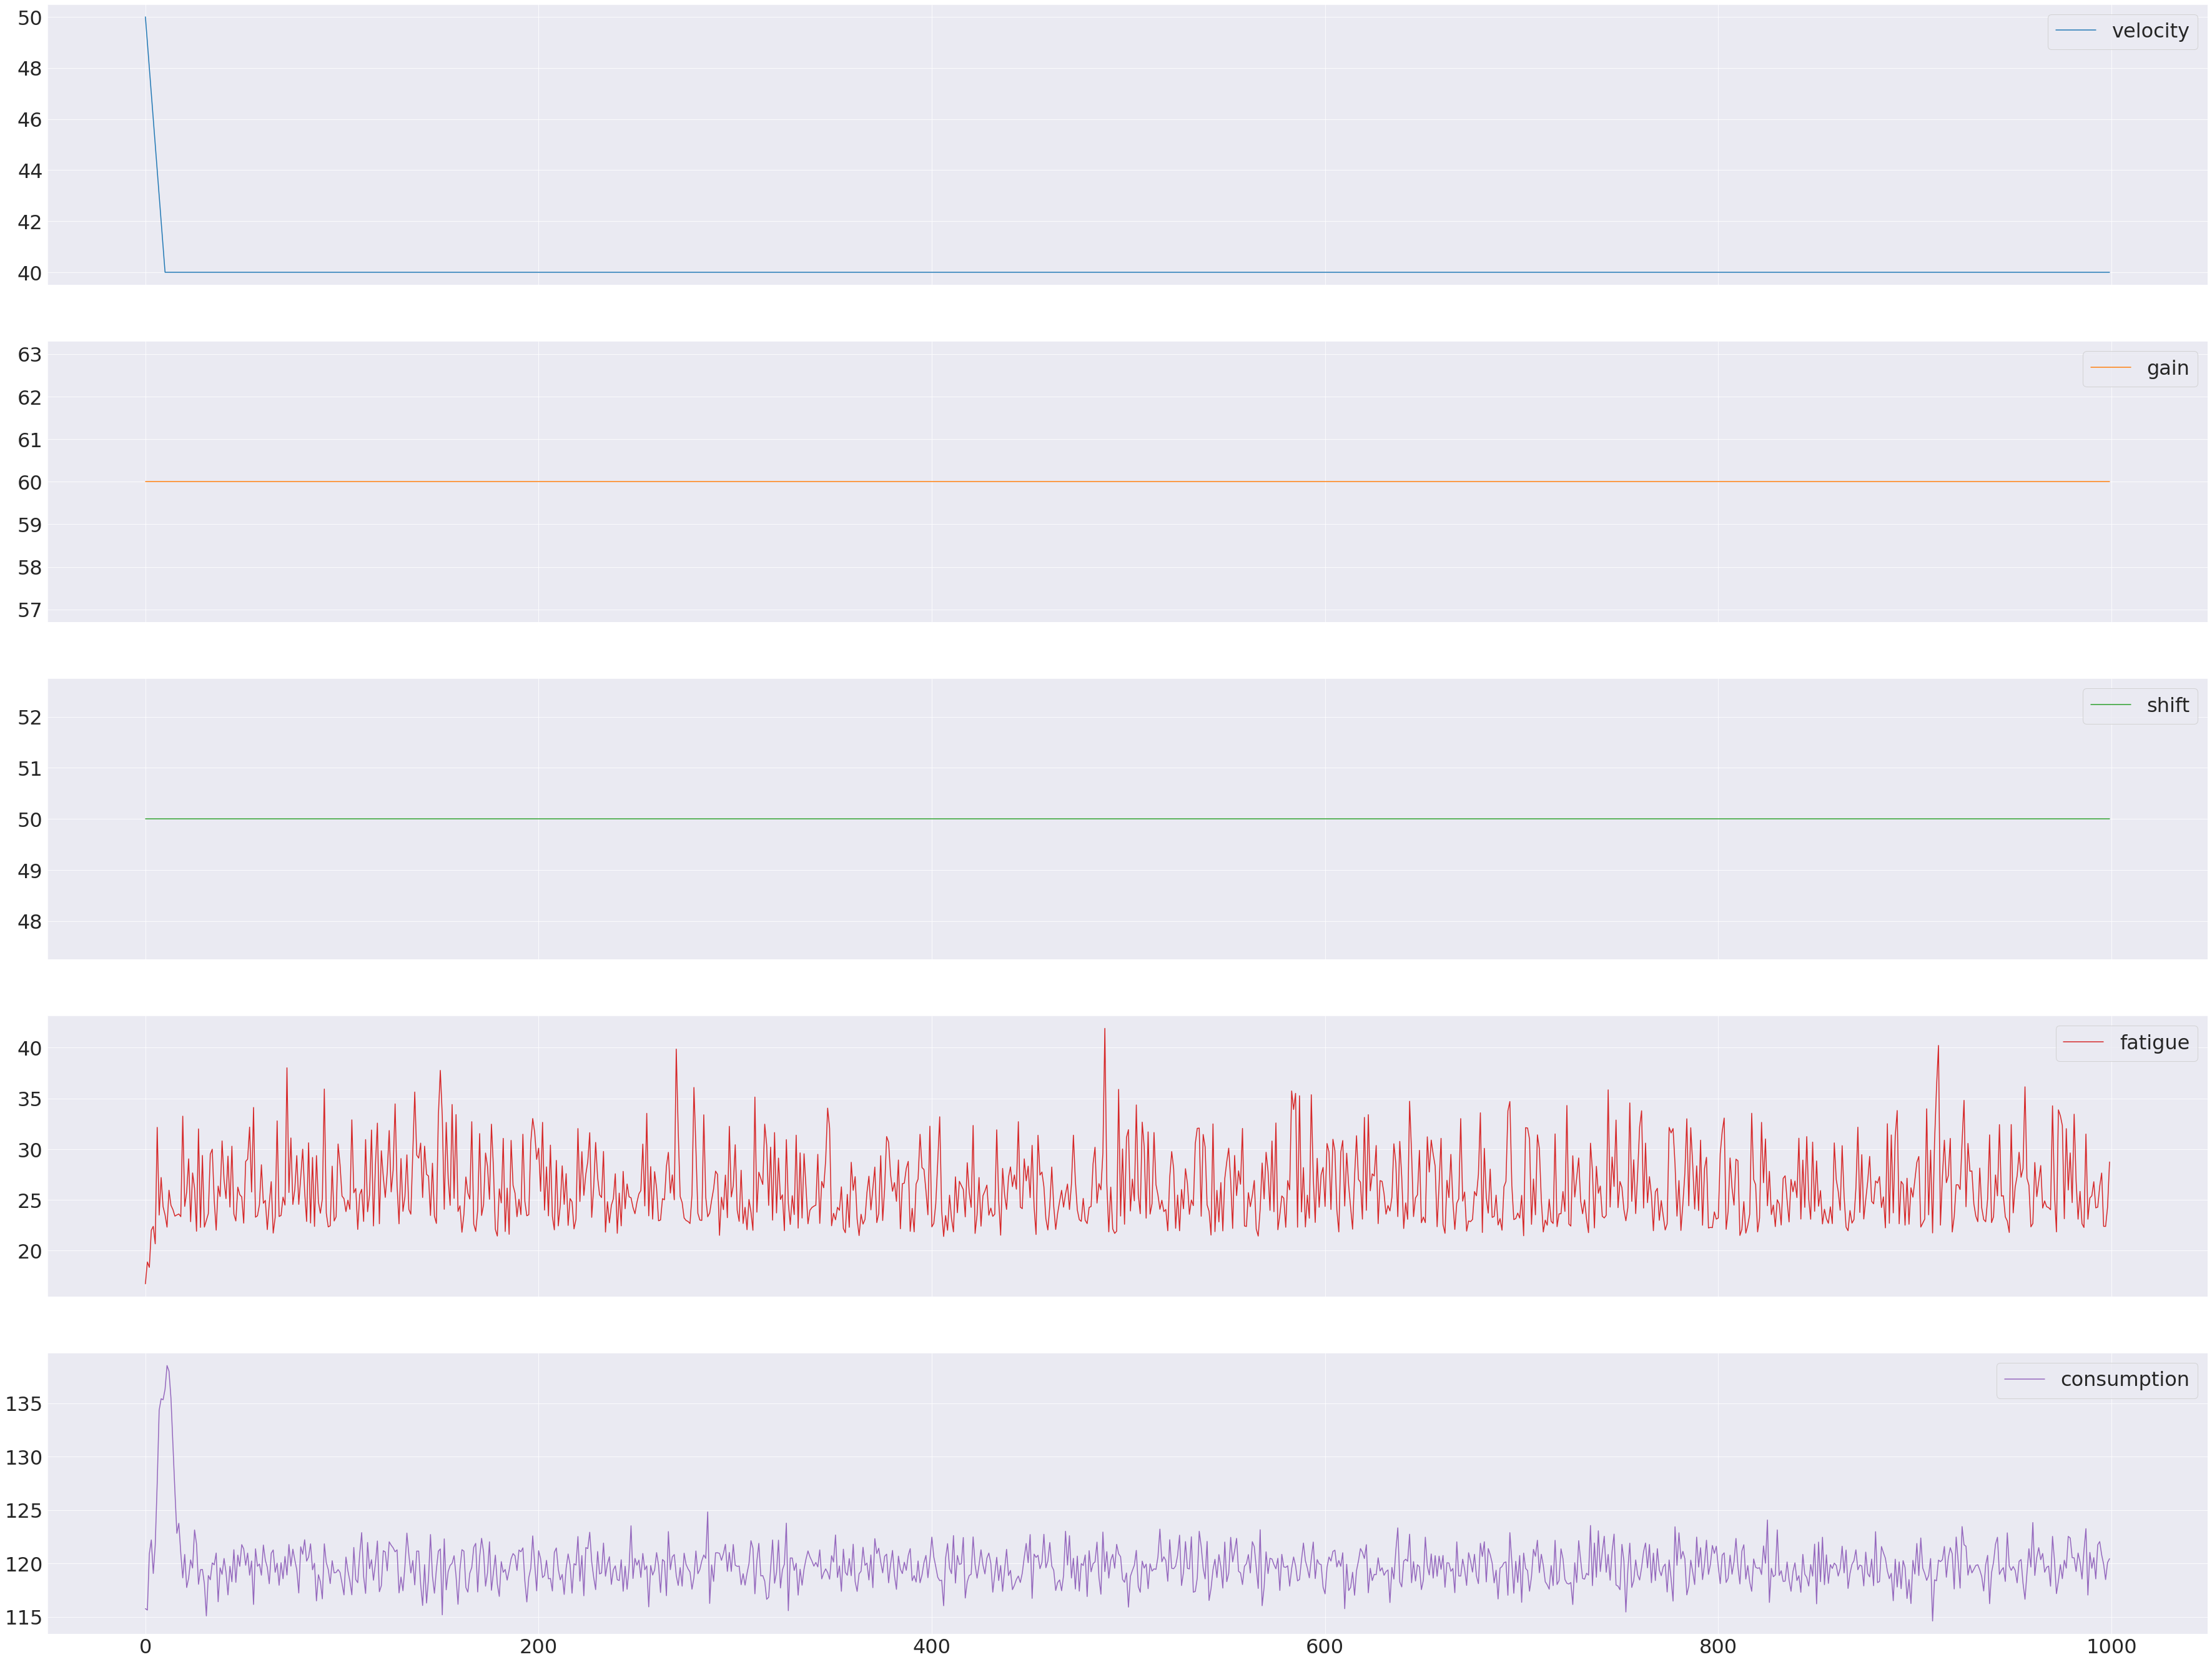

In [12]:
plot_industrial_benchmark_trajectories(policy_benchmarks.evaluators[-2].eval_trajectories[0]['info'])
np.mean(policy_benchmarks.evaluators[-2].eval_rewards_per_epoch)

In [7]:
df = pd.DataFrame(policy_benchmarks.benchmark_metrics)
df.T

,reward,std
ib_policy_trajectory_ep10_model_aeq,-299.687210,31.388033
ib_policy_trajectory_ep10_model_final_h,-315.714710,21.086423
ib_policy_trajectory_ep10_model_h_c,-197.866745,0.912798
ib_policy_trajectory_ep100_model_aeq,-218.971264,9.414145
ib_policy_trajectory_ep100_model_final_h,-227.742202,0.692444
ib_policy_trajectory_ep100_model_h_c,-216.347596,0.334241
ib_policy_trajectory_ep1000_model_aeq,-192.588389,1.225854
ib_policy_trajectory_ep1000_model_h_c,-198.007896,0.749903
ib_policy_trajectory_ep1000_model_final_h,-227.720965,0.517206


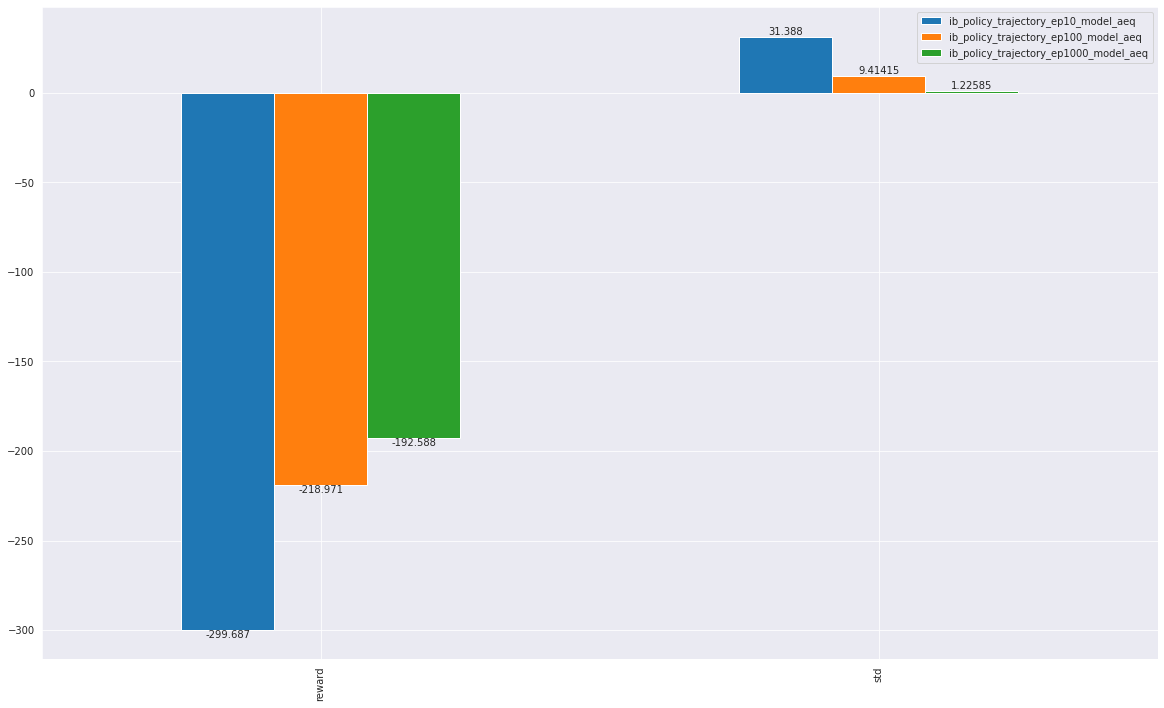

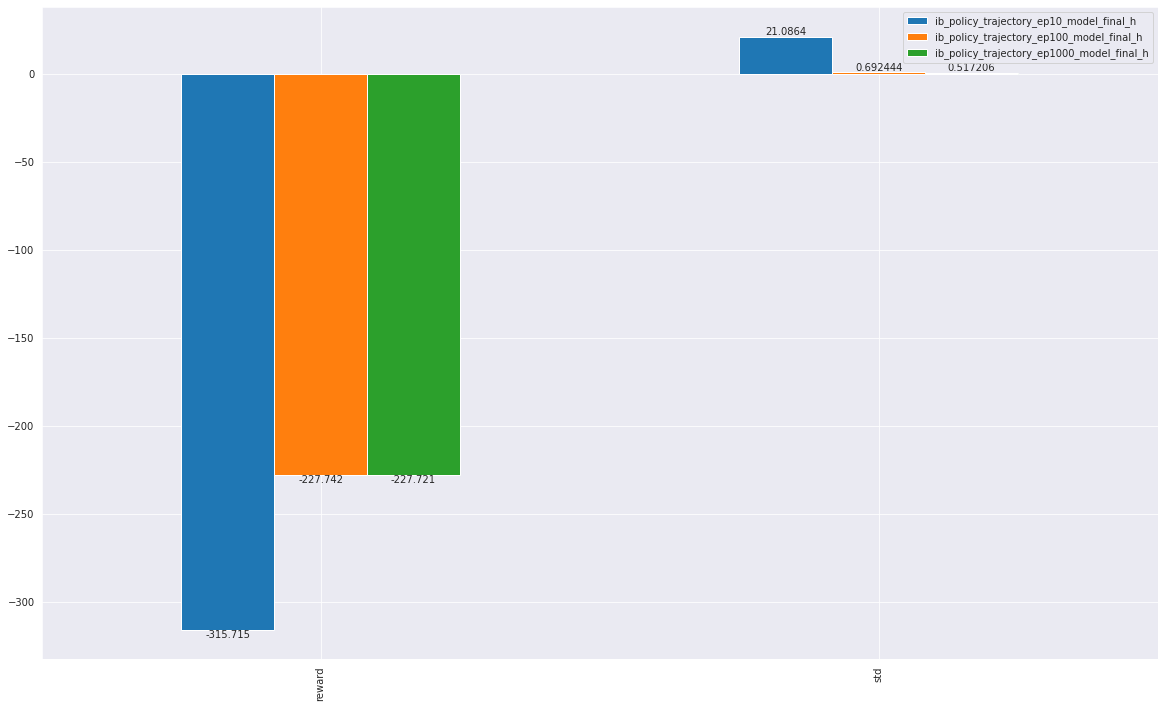

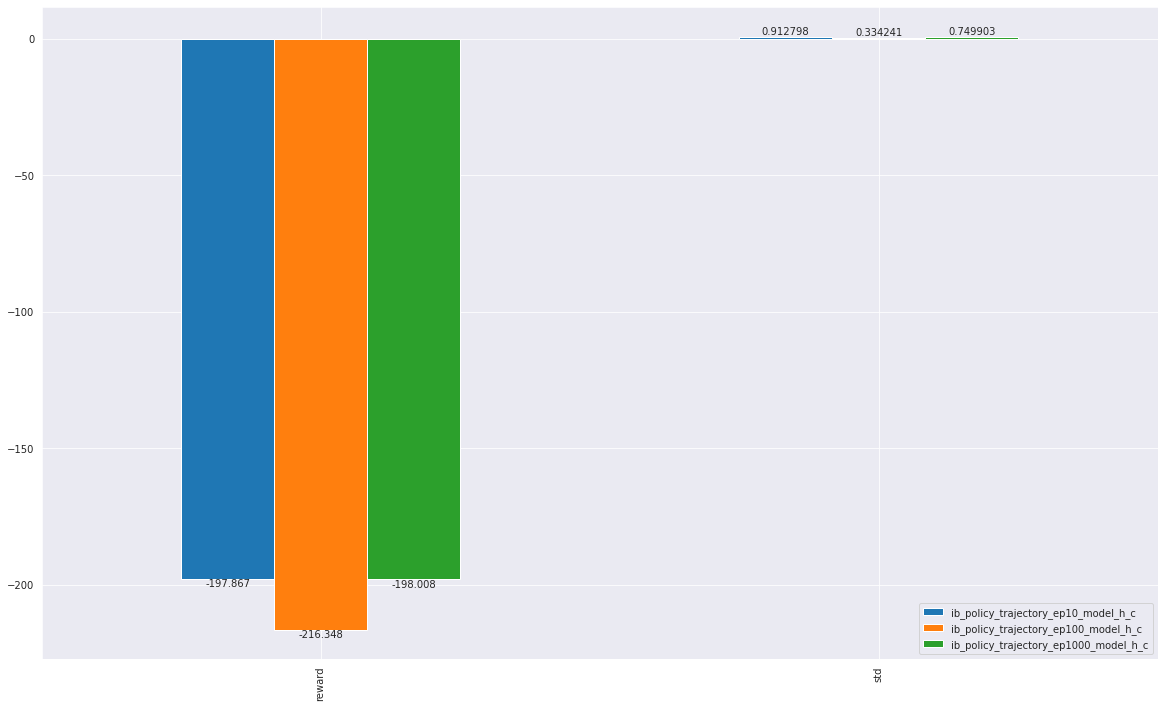

In [8]:
plt.rcParams["figure.figsize"] = [20, 12]

model_names_un = np.unique(model_names)
for model_name in model_names_un:
    m = np.core.defchararray.find(df.columns.values.astype(str), model_name) >= 0
    fdf = df.loc[:, m]
    ax = fdf.plot.bar()

    for container in ax.containers:
        ax.bar_label(container)
    plt.show()